# Multi-Class Classification with Machine Learning
In this notebook, we will explore various machine learning models to solve a multi-class classification problem. We will evaluate and compare the performance of different algorithms on the dataset.


In [67]:
import ast
import json
import re
import string
from collections import defaultdict
from pathlib import Path
from typing import Union, Any

import numpy
import pandas
import seaborn
import xgboost
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC

RANDOM_STATE = 42
TEST_SIZE = 2e-1

GLOVE_6B_300D_TXT = Path('models/glove.6B/glove.6B.300d.txt')
THREAT_TWEETS_CSV = Path('data/threat.tweets.csv')


In [2]:
def build_tree(categories):
    """
    Function to build a tree-like structure (nested dictionary)

    Parameters
    ----------
    categories

    Returns
    -------

    """
    tree = {}

    for category in categories:
        path = category['label'].strip('/').split('/')  # Split the label by '/'
        current = tree

        for part in path:
            if part not in current:
                current[part] = {}  # Add a new dictionary for the subcategory
            current = current[part]  # Move to the next level in the tree
    return tree


In [3]:
def merge_trees(tree1, tree2):
    """
    Merge two trees recursively.

    Parameters
    ----------
    tree1
    tree2

    Returns
    -------

    """
    for key, value in tree2.items():
        if key not in tree1:
            tree1[key] = value
        else:
            if isinstance(value, dict) and isinstance(tree1[key], dict):
                merge_trees(tree1[key], value)
    return tree1


In [4]:
def merge_all_trees(trees):
    """
    Remove duplicates and merge all trees into one general tree.

    Parameters
    ----------
    trees

    Returns
    -------

    """
    # Step 1: Remove duplicate trees by serializing and converting to set
    serialized_trees = {json.dumps(tree, sort_keys=True) for tree in trees}
    unique_trees = [json.loads(tree) for tree in serialized_trees]

    # Step 2: Merge all trees into one
    general_tree = {}
    for tree in unique_trees:
        general_tree = merge_trees(general_tree, tree)

    return general_tree


In [5]:
def merge_trees_with_counts(tree1, tree2, visit_count):
    """
    Merge two trees recursively, and count the visits to each node.

    Parameters
    ----------
    tree1
    tree2
    visit_count

    Returns
    -------

    """
    for key, value in tree2.items():
        if key not in tree1:
            tree1[key] = value
        else:
            if isinstance(value, dict) and isinstance(tree1[key], dict):
                merge_trees_with_counts(tree1[key], value, visit_count)

        # Count visits for the node
        visit_count[key] += 1
    return tree1


In [6]:
def merge_all_trees_with_counts(trees):
    """
    Merge all trees into one general tree and count the visits to each node.

    Parameters
    ----------
    trees

    Returns
    -------

    """
    # Initialize a visit count dictionary
    visit_count = defaultdict(int)

    # Step 1: Remove duplicate trees by serializing and converting to set
    serialized_trees = {json.dumps(tree, sort_keys=True) for tree in trees}
    unique_trees = [json.loads(tree) for tree in serialized_trees]

    # Step 2: Merge all unique trees into one tree while counting visits
    general_tree = {}
    for tree in unique_trees:
        general_tree = merge_trees_with_counts(general_tree, tree, visit_count)

    return general_tree, visit_count


In [7]:
def extract_leaves(tree):
    leaves = []

    # If the current node is a dictionary
    if isinstance(tree, dict):
        # Check each key and value in the current dictionary
        for key, value in tree.items():
            # If the value is an empty dictionary, it's a leaf node
            if isinstance(value, dict) and not value:
                leaves.append(key)
            # Otherwise, recursively check the value
            else:
                leaves.extend(extract_leaves(value))

    return leaves


In [50]:
def extract_keys(d, path=None):
    """
    Define a recursive function to extract keys

    Parameters
    ----------
    d
    path

    Returns
    -------

    """
    if path is None:
        path = []

    if isinstance(d, dict):
        for key, value in d.items():
            path = extract_keys(value, path + [key])
    else:
        path = [d]

    return path


In [17]:
def process_row(row):
    """
    Function to convert string to dict and extract keys

    Parameters
    ----------
    row

    Returns
    -------

    """
    # Extract keys by traversing the dictionary
    return extract_keys(row)


In [64]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[
    Union[str, list[str]], numpy.ndarray[Any, numpy.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def preprocess_texts(list_str, model_path, embedding_dim):
    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = numpy.zeros((len(list_str), embedding_dim))
    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)
        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue
    return list_embedded_str


## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading & Preprocessing](#Data-Loading-&-Preprocessing)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
4. [Model Training](#Model-Training)
    1. [Logistic Regression](#Logistic-Regression)
    2. [Random Forest Classifier](#Random-Forest-Classifier)
    3. [Support Vector Machine (SVM)](#Support-Vector-Machine-(SVM))
    4. [K-Nearest Neighbors (KNN)](#K-Nearest-Neighbors-(KNN))
    5. [XGBoost Classifier](#XGBoost-Classifier)
5. [Model Evaluation](#Model-Evaluation)
    1. [Accuracy](#Accuracy)
    2. [Confusion Matrix](#Confusion-Matrix)
    3. [Classification Report](#Classification-Report)
6. [Conclusion](#Conclusion)


## 1. Introduction

In this notebook, we are going to solve a multi-class classification problem using different machine learning models. Our goal is to predict the class of each sample based on the input features.

## 2. Data Loading & Preprocessing
We will load the dataset, inspect its structure, and preprocess it for machine learning models.


In [51]:
# Read the CSV file
threat_tweets = pandas.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)

# Convert the 'watson' column from string representation of dict to actual dict
threat_tweets['watson'] = threat_tweets['watson'].apply(ast.literal_eval)
threat_tweets['tweet'] = threat_tweets['tweet'].apply(ast.literal_eval)

# Extract 'categories' field (list of dictionaries)
categories = threat_tweets['watson'].apply(lambda x: x.get('categories', []))

# Build a tree for each row's categories
category_tree = categories.apply(build_tree)

# Remove duplicates and merge all trees into one
general_tree, visit_count = merge_all_trees_with_counts(category_tree)

threat_tweets['watson'] = category_tree.apply(process_row)


In [52]:
threat_tweets.head()


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"[science, social science, philosophy, ethics, ...",irrelevant,[],NaN,NaN
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"[technology and computing, computer security, ...",business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"[technology and computing, computer security, ...",business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"[technology and computing, internet technology...",threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"[travel, hotels, home and garden, home improve...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True


In [59]:
print('At the top of the hierarchical structure there are:')
for category in list(general_tree.keys()):
    print(f'· {category}')


At the top of the hierarchical structure there are:
· technology and computing
· law, govt and politics
· science
· art and entertainment
· travel
· hobbies and interests
· news
· business and industrial
· society
· health and fitness
· family and parenting
· automotive and vehicles
· education
· food and drink
· sports
· home and garden
· shopping
· style and fashion
· finance
· pets
· religion and spirituality
· careers
· real estate


In [60]:
print('General Tree:')
print(json.dumps(general_tree, indent=4))


General Tree:
{
    "technology and computing": {
        "hardware": {
            "computer": {
                "portable computer": {
                    "tablet": {},
                    "laptop": {},
                    "palmtops and pdas": {}
                },
                "servers": {},
                "desktop computer": {}
            },
            "computer components": {
                "motherboards": {},
                "disks": {},
                "chips and processors": {},
                "memory": {
                    "portable": {}
                },
                "graphics cards": {},
                "sound cards": {}
            },
            "computer networking": {
                "router": {},
                "wireless technology": {}
            },
            "computer peripherals": {
                "printers, copiers and fax": {
                    "scanners": {},
                    "fax machines": {},
                    "printers": {},
           

In [62]:
print('For the goal of the project, the category "technology and computing" is the only one of interest.')
print(json.dumps(general_tree['technology and computing'], indent=4))


For the goal of the project, the category "technology and computing" is the only one of interest.
{
    "hardware": {
        "computer": {
            "portable computer": {
                "tablet": {},
                "laptop": {},
                "palmtops and pdas": {}
            },
            "servers": {},
            "desktop computer": {}
        },
        "computer components": {
            "motherboards": {},
            "disks": {},
            "chips and processors": {},
            "memory": {
                "portable": {}
            },
            "graphics cards": {},
            "sound cards": {}
        },
        "computer networking": {
            "router": {},
            "wireless technology": {}
        },
        "computer peripherals": {
            "printers, copiers and fax": {
                "scanners": {},
                "fax machines": {},
                "printers": {},
                "copiers": {}
            },
            "computer monitors":

In [63]:
sorted_visit_count = dict(sorted(visit_count.items(), key=lambda item: item[1], reverse=True))

print('Visit Counts:')
print(json.dumps(sorted_visit_count, indent=4))


Visit Counts:
{
    "technology and computing": 5843,
    "computer security": 3254,
    "art and entertainment": 2514,
    "society": 1869,
    "business and industrial": 1832,
    "law, govt and politics": 1717,
    "antivirus and malware": 1657,
    "network security": 1657,
    "health and fitness": 1593,
    "software": 1177,
    "science": 1110,
    "hardware": 915,
    "crime": 897,
    "hobbies and interests": 825,
    "movies and tv": 790,
    "travel": 682,
    "sports": 646,
    "family and parenting": 621,
    "music": 611,
    "government": 610,
    "finance": 581,
    "disease": 577,
    "consumer electronics": 565,
    "disorders": 553,
    "legal issues": 529,
    "computer": 521,
    "personal offense": 491,
    "movies": 490,
    "education": 488,
    "home and garden": 487,
    "food and drink": 461,
    "databases": 447,
    "mental disorder": 413,
    "operating systems": 412,
    "style and fashion": 407,
    "tourist destinations": 402,
    "children": 400,
    "

In [64]:
leaves = extract_leaves(general_tree)
leaves_visit_counts = {key: visit_count[key] for key in leaves if key in sorted_visit_count}

print('Visit Counts for the leaves categories:')
print(json.dumps(dict(sorted(leaves_visit_counts.items(), key=lambda item: item[1], reverse=True)), indent=4))


Visit Counts for the leaves categories:
{
    "antivirus and malware": 1657,
    "network security": 1657,
    "databases": 447,
    "panic and anxiety": 290,
    "kidnapping": 241,
    "unrest and war": 236,
    "vpn and remote access": 210,
    "humor": 197,
    "javascript": 182,
    "linux": 160,
    "reading": 149,
    "human rights": 148,
    "router": 143,
    "conference": 142,
    "podcasts": 129,
    "police": 128,
    "fraud": 124,
    "statistics": 118,
    "guitar": 118,
    "disks": 117,
    "depression": 112,
    "plumbing": 109,
    "computer crime": 108,
    "mp3 and midi": 107,
    "tech news": 101,
    "larceny": 100,
    "social network": 98,
    "television": 98,
    "assault": 98,
    "marketing": 97,
    "xbox": 96,
    "flood": 96,
    "running and jogging": 96,
    "dogs": 96,
    "smart phones": 95,
    "credit cards": 95,
    "annual report": 93,
    "aids and hiv": 93,
    "windows": 92,
    "pottery": 91,
    "homicide": 91,
    "email": 90,
    "terrorism"

In [73]:
threat_tweets['target'] = [
    list(set(general_tree['technology and computing'].keys()) & set(s))
    for s in threat_tweets['watson']
]

for i, t_list in enumerate(threat_tweets['target']):
    temp = t_list.copy()
    for t in t_list:
        if visit_count[t] < 2:
            temp.remove(t)
    threat_tweets['target'][i] = temp


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [74]:
mlb = MultiLabelBinarizer()
target = mlb.fit_transform(threat_tweets['target'])
df_binary = pandas.DataFrame(target, columns=mlb.classes_)
df_binary.head()


,computer certification,computer crime,computer reviews,computer security,consumer electronics,data centers,electronic components,enterprise technology,hardware,internet technology,mp3 and midi,networking,operating systems,programming languages,software,tech news,technical support,technological innovation
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
X = preprocess_texts(
    list_str=threat_tweets['text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
)

x_train, x_test, y_train, y_test = train_test_split(
    X, target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target
)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## 3. Exploratory Data Analysis (EDA)
Let's analyze the dataset and gain insights into its distribution.


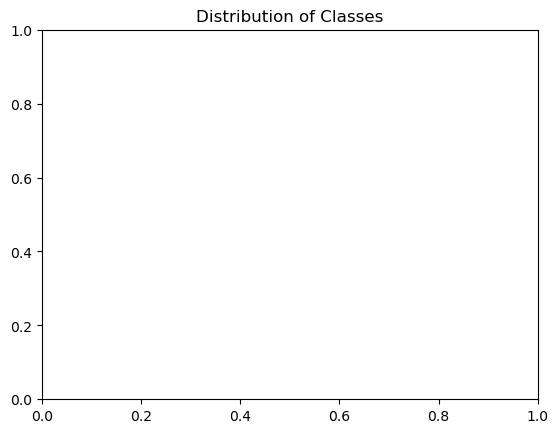

ValueError: could not convert string to float: "b'5b88752abb325e65390af240'"

In [70]:
# Visualize the distribution of the target classes
seaborn.countplot(threat_tweets['target'])
plt.title('Distribution of Classes')
plt.show()

# Visualize correlations between features (if applicable)
seaborn.heatmap(threat_tweets.corr(), annot=True)
plt.title('Feature Correlation Matrix')
plt.show()


## 4. Model Training

We will now train different models and evaluate their performance.


### 4.1 Logistic Regression


In [ ]:
# Prepare the data
X = threat_tweets.drop('target', axis=1)
y = threat_tweets['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {log_reg_accuracy:.4f}')


### 4.2 Random Forest Classifier


In [ ]:
# Initialize the model
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


### 4.3 Support Vector Machine (SVM)


In [ ]:
# Initialize the model
svm_model = SVC()

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy:.4f}')


### 4.4 K-Nearest Neighbors (KNN)

In [ ]:
# Initialize the model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {knn_accuracy:.4f}')


### 4.5 XGBoost Classifier


In [ ]:
# Initialize the model
xgb_model = xgboost.XGBClassifier()

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')


## 5. Model Evaluation

Now that we've trained the models, let's evaluate them in more detail.


### 5.1 Accuracy


In [ ]:
print(f'Logistic Regression Accuracy: {log_reg_accuracy:.4f}')
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'SVM Accuracy: {svm_accuracy:.4f}')
print(f'KNN Accuracy: {knn_accuracy:.4f}')
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')


### 5.2 Confusion Matrix


In [ ]:
# Confusion matrix for the Random Forest model as an example
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
seaborn.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 5.3 Classification Report


In [ ]:
# Classification report for Random Forest
print(classification_report(y_test, y_pred_rf))


6. Conclusion

In this notebook, we tried several machine learning models to solve a multi-class classification problem. The models evaluated include Logistic Regression, Random Forest, SVM, KNN, and XGBoost. Based on the results, we can decide which model performs best for the given problem.

    Logistic Regression: accuracy = X
    Random Forest: accuracy = X
    SVM: accuracy = X
    KNN: accuracy = X
    XGBoost: accuracy = X

Further improvements could be made through hyperparameter tuning or using ensemble methods.
